In [ ]:
# 라이브러리 임포트
import os
import zipfile
from google.colab import drive
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Google Drive 연결
drive.mount('/content/drive')

# 데이터셋 로드 및 분할
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    with_info=True,
    as_supervised=True,
)

IMG_SIZE = (224, 224)

# 데이터 증강 및 전처리 (훈련 및 검증용)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def preprocess_train(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = data_augmentation(image)
    image = preprocess_input(image)
    label = tf.cast(label, tf.float32)
    return image, label

def preprocess_validation(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    label = tf.cast(label, tf.float32)
    return image, label

# 전처리 적용
BATCH_SIZE = 32

ds_train = ds_train.map(preprocess_train).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess_validation).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 테스트 데이터 전처리 (데이터 증강 제외)
def preprocess_test(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    label = tf.cast(label, tf.float32)
    return image, label

ds_test = ds_test.map(preprocess_test).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 테스트 데이터셋 저장 디렉토리 생성
test_dir = '/content/test_dataset'
os.makedirs(test_dir, exist_ok=True)

def save_test_images(dataset, save_dir):
    for i, (image, label) in enumerate(dataset.unbatch().take(-1)):
        label_dir = os.path.join(save_dir, 'dogs' if label.numpy() == 1 else 'cats')
        os.makedirs(label_dir, exist_ok=True)
        image_path = os.path.join(label_dir, f'image_{i}.jpg')
        tf.keras.utils.save_img(image_path, image.numpy())

# 테스트 데이터셋 저장
save_test_images(ds_test, test_dir)

# 테스트 데이터셋 압축
zip_path = '/content/drive/MyDrive/test_dataset.zip'
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, _, files in os.walk(test_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, start=test_dir)
            zipf.write(file_path, arcname)

print(f"Test dataset saved and compressed at {zip_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Test dataset saved and compressed at /content/drive/MyDrive/test_dataset.zip


In [ ]:
# 모델 구성
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = True  # 모든 층 학습 가능

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
EPOCHS = 6

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# 학습 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

Epoch 1/6
509/509 ━━━━━━━━━━━━━━━━━━━━ 399s 621ms/step - accuracy: 0.9140 - loss: 0.2099 - val_accuracy: 0.9914 - val_loss: 0.0278
Epoch 2/6
509/509 ━━━━━━━━━━━━━━━━━━━━ 282s 490ms/step - accuracy: 0.9843 - loss: 0.0451 - val_accuracy: 0.9928 - val_loss: 0.0206
Epoch 3/6
509/509 ━━━━━━━━━━━━━━━━━━━━ 1426s 3s/step - accuracy: 0.9887 - loss: 0.0279 - val_accuracy: 0.9928 - val_loss: 0.0193
Epoch 4/6
509/509 ━━━━━━━━━━━━━━━━━━━━ 268s 502ms/step - accuracy: 0.9913 - loss: 0.0225 - val_accuracy: 0.9917 - val_loss: 0.0220
Epoch 5/6


In [ ]:
# 모델 저장
saved_model_path = '/content/drive/MyDrive/saved_model/efficientnetb0_model.h5'
model.save(saved_model_path)

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.9927 - loss: 0.0215
Test Accuracy: 99.10%
Test Loss: 0.0248
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


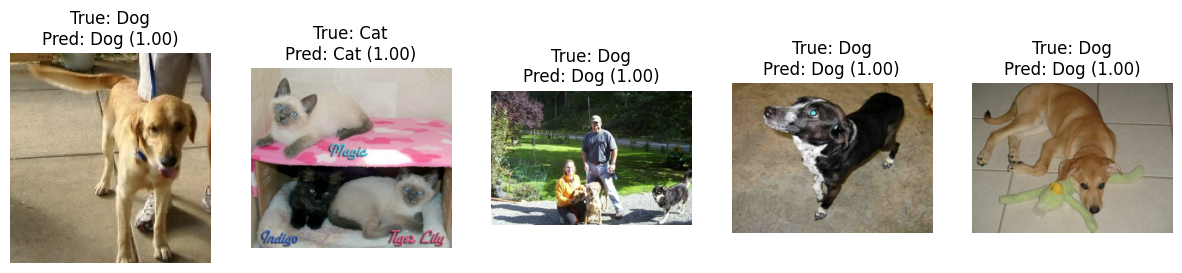

In [ ]:
# 저장된 모델 로드
loaded_model = tf.keras.models.load_model(saved_model_path)

# 테스트 데이터셋 평가
test_loss, test_accuracy = loaded_model.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# 모델 테스트: 일부 샘플 시각화 및 예측 결과 확인
def display_and_predict(model, dataset, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        # 이미지 예측
        image_resized = tf.image.resize(image, IMG_SIZE)
        image_preprocessed = preprocess_input(image_resized)
        prediction = model.predict(tf.expand_dims(image_preprocessed, axis=0))[0][0]

        # 실제 레이블과 예측 레이블
        true_label = "Dog" if label == 1 else "Cat"
        predicted_label = "Dog" if prediction > 0.5 else "Cat"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        # 이미지 시각화
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"True: {true_label}\nPred: {predicted_label} ({confidence:.2f})")
        plt.axis("off")
    plt.show()

# 테스트 데이터셋에서 샘플 확인
display_and_predict(loaded_model, raw_test_data)